# Analysis of bottle data & machine learning model development
Created by Ivan Lima on Wed Oct  6 2021 09:10:39 -0400

In this notebook we develop machine learning models to estimate DIC and total alkalitiny from merged bottle and satellite data, excluding dissolved oxygen as input variable.

We develop and compare three different machine learning models:

- Random forest regression
- Gradient boosting regression
- Neural network regression

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, datetime, warnings
print('Last updated on {}'.format(datetime.datetime.now().ctime()))

Last updated on Mon Mar  7 09:45:20 2022


In [2]:
sns.set_theme(context='paper', style='ticks', palette='tab10', rc={'figure.dpi':100, 'figure.figsize':[5, 5], 'axes.grid':True})
pd.options.display.max_columns = 50
warnings.filterwarnings('ignore')

In [3]:
# turn off GridSearchCV anoying warnings when n_jobs=-1
import sys, warnings
warnings.filterwarnings('ignore')
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

## Read merged data

In [4]:
df = pd.read_csv('data/bottle_satellite_data_clean.csv', parse_dates=['Date'], index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2601 entries, 0 to 3039
Data columns (total 47 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   X.x                  2601 non-null   int64         
 1   X.y                  2601 non-null   int64         
 2   DOI                  2601 non-null   object        
 3   EXPOCODE             1466 non-null   object        
 4   Accession            101 non-null    float64       
 5   Cruise_ID            2022 non-null   object        
 6   Date                 2601 non-null   datetime64[ns]
 7   Year                 2601 non-null   int64         
 8   Month                2601 non-null   int64         
 9   Day                  2601 non-null   int64         
 10  Time_UTC             2521 non-null   object        
 11  Latitude             2601 non-null   float64       
 12  Longitude            2601 non-null   float64       
 13  Depth_bottom         1341 non-nul

## Machine Learning models

Models to compare:

- Random Forest regression
- Gradient Boosting regression
- Neural Network regression

To optimize model performance, we tune each model's parameters by searching through parameter space using k-fold cross-validation to evaluate the model's generalization performance.

### Select input features and split data into training and test sets 

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

# Set input and output variables
features = ['Depth', 'bottom_depth', 'Temperature', 'Salinity', 'pCO2_monthave', 'SLA', 'SST_hires', 'log_KD490']
targets  = ['DIC', 'TA']

X = df[features].values
Y = df[targets].values

# Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

### Correlation between feature and target variables 

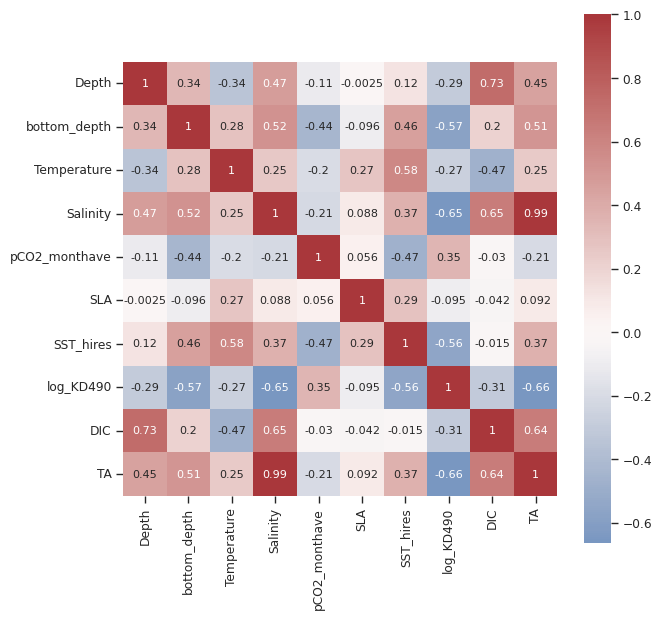

In [6]:
data = df[features + targets]
corr_mat = data.corr()
fig, ax = plt.subplots(figsize=(7,7))
_ = sns.heatmap(corr_mat, ax=ax, cmap='vlag', center=0, square=True, annot=True, annot_kws={'fontsize':8})

### Random Forest regression 

Best cross-validation score: 0.964
Best parameters: {'max_features': 'log2', 'n_estimators': 900}
Best estimator: RandomForestRegressor(max_features='log2', n_estimators=900, random_state=0)
Training set score: 0.995
Test set score:     0.965
Final model cross-validation mean score: 0.939


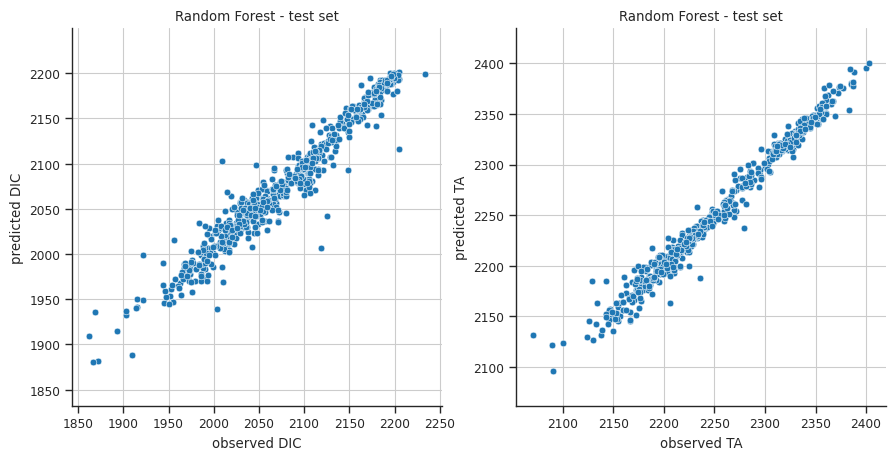

In [7]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {'n_estimators': [700, 900, 1100],
              'max_features' : [None, 'sqrt', 'log2']}
gs_rfr = GridSearchCV(RandomForestRegressor(random_state=0), param_grid, cv=5, n_jobs=-1)
gs_rfr.fit(X_train, Y_train);

print('Best cross-validation score: {:.3f}'.format(gs_rfr.best_score_))
print('Best parameters: {}'.format(gs_rfr.best_params_))
print('Best estimator: {}'.format(gs_rfr.best_estimator_))

print('Training set score: {:.3f}'.format(gs_rfr.score(X_train, Y_train)))
print('Test set score:     {:.3f}'.format(gs_rfr.score(X_test, Y_test)))

scores = cross_val_score(gs_rfr.best_estimator_, X, Y, cv=5, n_jobs=-1)
print('Final model cross-validation mean score: {:.3f}'.format(scores.mean()))

Y_pred = gs_rfr.predict(X_test)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10.5, 5))
_ = sns.scatterplot(x=Y_test[:,0], y=Y_pred[:,0], ax=ax0)
_ = sns.scatterplot(x=Y_test[:,1], y=Y_pred[:,1], ax=ax1)
_ = ax0.set(xlabel='observed DIC', ylabel='predicted DIC', title='Random Forest - test set')
_ = ax1.set(xlabel='observed TA', ylabel='predicted TA', title='Random Forest - test set')
ax0.axis('equal')
ax1.axis('equal')
sns.despine(fig)

#### Feature importance

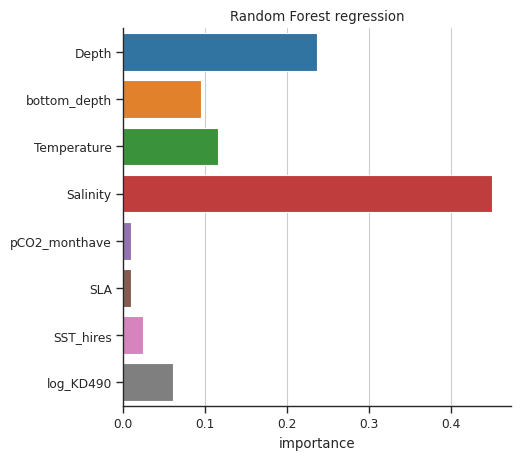

In [8]:
df_rfr = pd.DataFrame(gs_rfr.best_estimator_.feature_importances_, index=features, columns=['importance'])
fig, ax = plt.subplots()
_ = sns.barplot(data=df_rfr, y=df_rfr.index, x='importance', orient='horizontal', ax=ax)
_ = ax.set_title('Random Forest regression')
sns.despine(fig)

### Gradient Boosting regression 

Gradient boosting regression does not support multiple outputs so here we try two different approaches to estimate DIC and TA:

1. **Independent regressors**: Fit one regressor per target. This assumes that DIC and TA are independent from each other.
2. **Chained regressors**: Combine the regressors into a sequencial chain, where we first use the input features to predict one target and then use the input features + first target to predict the second target. This approach takes into account the fact the DIC and TA are correlated. We do this in two different ways:
    1. Use the input features to predict TA, and then use the input features + TA to predict DIC.
    2. Use the input features to predict DIC, and then use the input features + DIC to predict TA.

#### Independent regressors

Best cross-validation score: 0.967
Best parameters: {'estimator__learning_rate': 0.01, 'estimator__max_depth': 4, 'estimator__n_estimators': 2200}
Best estimator: MultiOutputRegressor(estimator=GradientBoostingRegressor(learning_rate=0.01,
                                                         max_depth=4,
                                                         n_estimators=2200,
                                                         random_state=0))
Training set score: 0.992
Test set score:     0.966
Final model cross-validation mean score: 0.943


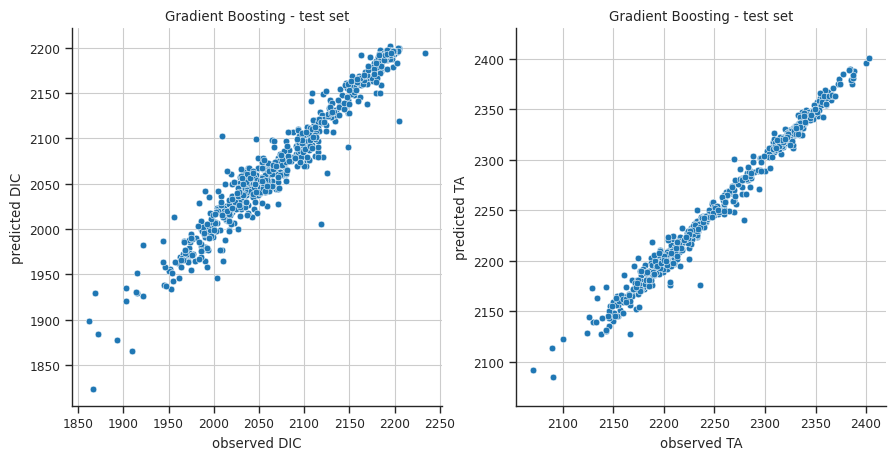

In [9]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {'estimator__n_estimators': [1800, 2000, 2200],
              'estimator__learning_rate':[0.01, 0.1],
              'estimator__max_depth':[3, 4]}
gs_gbr = GridSearchCV(MultiOutputRegressor(GradientBoostingRegressor(random_state=0)), param_grid, cv=5, n_jobs=-1)
gs_gbr.fit(X_train, Y_train);

print('Best cross-validation score: {:.3f}'.format(gs_gbr.best_score_))
print('Best parameters: {}'.format(gs_gbr.best_params_))
print('Best estimator: {}'.format(gs_gbr.best_estimator_))

print('Training set score: {:.3f}'.format(gs_gbr.score(X_train, Y_train)))
print('Test set score:     {:.3f}'.format(gs_gbr.score(X_test, Y_test)))

scores = cross_val_score(gs_gbr.best_estimator_, X, Y, cv=5, n_jobs=-1)
print('Final model cross-validation mean score: {:.3f}'.format(scores.mean()))

Y_pred = gs_gbr.predict(X_test)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10.5, 5))
_ = sns.scatterplot(x=Y_test[:,0], y=Y_pred[:,0], ax=ax0)
_ = sns.scatterplot(x=Y_test[:,1], y=Y_pred[:,1], ax=ax1)
_ = ax0.set(xlabel='observed DIC', ylabel='predicted DIC', title='Gradient Boosting - test set')
_ = ax1.set(xlabel='observed TA', ylabel='predicted TA', title='Gradient Boosting - test set')
ax0.axis('equal')
ax1.axis('equal')
sns.despine(fig)

##### Feature importance

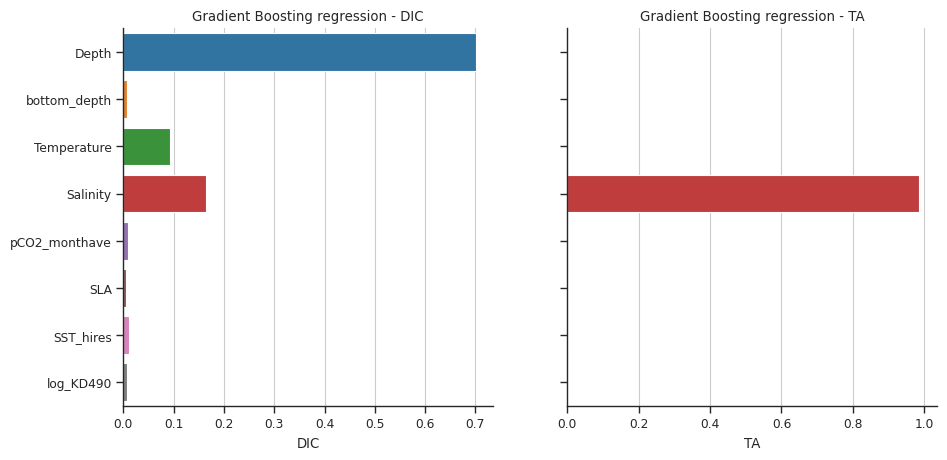

In [10]:
df_gbr = pd.DataFrame(np.c_[gs_gbr.best_estimator_.estimators_[0].feature_importances_,
                            gs_gbr.best_estimator_.estimators_[1].feature_importances_], index=features, columns=['DIC','TA'])
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10.5,5))
_ = sns.barplot(data=df_gbr, y=df_gbr.index, x='DIC', orient='horizontal', ax=axs[0])
_ = sns.barplot(data=df_gbr, y=df_gbr.index, x='TA', orient='horizontal', ax=axs[1])
_ = axs[0].set_title('Gradient Boosting regression - DIC')
_ = axs[1].set_title('Gradient Boosting regression - TA')
sns.despine(fig)

#### Chained regressors

$TA = f(X)$

$DIC = f(X,TA)$

Best cross-validation score: 0.967
Best parameters: {'base_estimator__learning_rate': 0.1, 'base_estimator__max_depth': 4, 'base_estimator__n_estimators': 1300}
Best estimator: RegressorChain(base_estimator=GradientBoostingRegressor(max_depth=4,
                                                        n_estimators=1300,
                                                        random_state=0),
               order=[1, 0])
Training set score: 0.999
Test set score:     0.967
Final model cross-validation mean score: 0.944


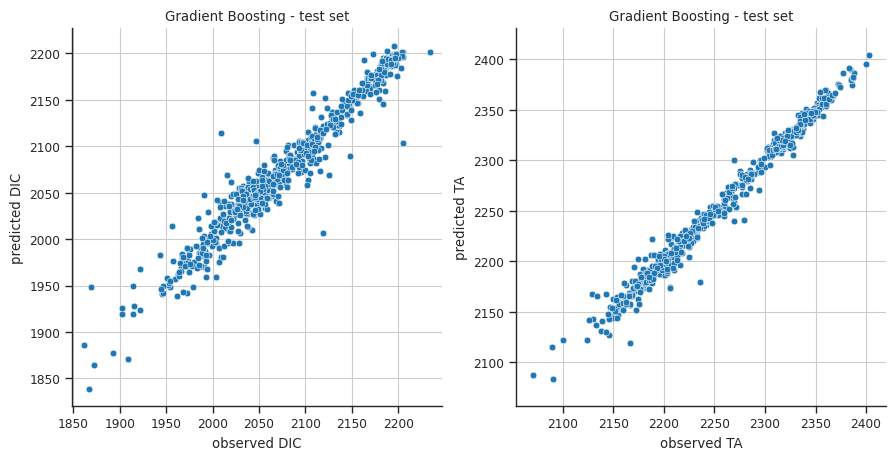

In [11]:
from sklearn.multioutput import RegressorChain

param_grid = {'base_estimator__n_estimators': [1300, 1500, 1700],
              'base_estimator__learning_rate':[0.01, 0.1],
              'base_estimator__max_depth':[3, 4]}
gs_gbrc = GridSearchCV(RegressorChain(GradientBoostingRegressor(random_state=0), order=[1,0]), param_grid, cv=5, n_jobs=-1)
gs_gbrc.fit(X_train, Y_train);

print('Best cross-validation score: {:.3f}'.format(gs_gbrc.best_score_))
print('Best parameters: {}'.format(gs_gbrc.best_params_))
print('Best estimator: {}'.format(gs_gbrc.best_estimator_))

print('Training set score: {:.3f}'.format(gs_gbrc.score(X_train, Y_train)))
print('Test set score:     {:.3f}'.format(gs_gbrc.score(X_test, Y_test)))

scores = cross_val_score(gs_gbrc.best_estimator_, X, Y, cv=5, n_jobs=-1)
print('Final model cross-validation mean score: {:.3f}'.format(scores.mean()))

Y_pred = gs_gbrc.predict(X_test)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10.5, 5))
_ = sns.scatterplot(x=Y_test[:,0], y=Y_pred[:,0], ax=ax0)
_ = sns.scatterplot(x=Y_test[:,1], y=Y_pred[:,1], ax=ax1)
_ = ax0.set(xlabel='observed DIC', ylabel='predicted DIC', title='Gradient Boosting - test set')
_ = ax1.set(xlabel='observed TA', ylabel='predicted TA', title='Gradient Boosting - test set')
ax0.axis('equal')
ax1.axis('equal')
sns.despine(fig)

##### Feature importance

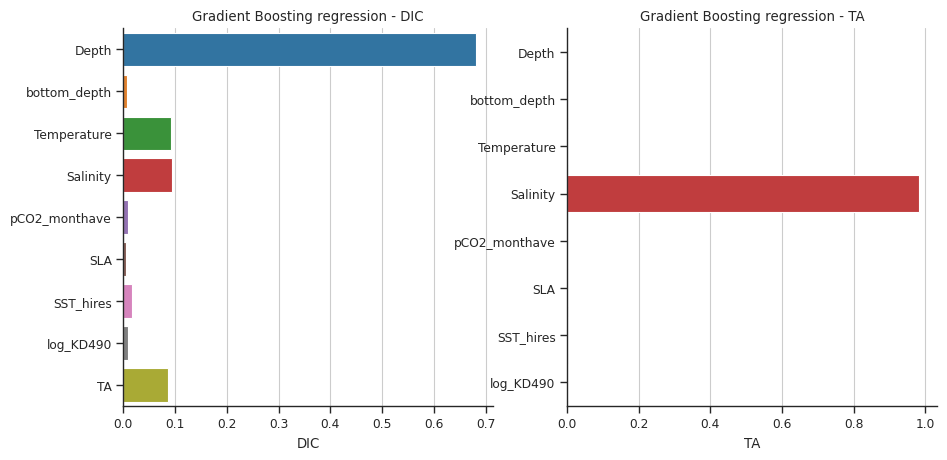

In [12]:
df1 = pd.DataFrame(gs_gbrc.best_estimator_.estimators_[0].feature_importances_, index=features, columns=['TA'])
df2 = pd.DataFrame(gs_gbrc.best_estimator_.estimators_[1].feature_importances_, index=features+['TA'], columns=['DIC'])
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10.5,5))
_ = sns.barplot(data=df2, y=df2.index, x='DIC', orient='horizontal', ax=ax0)
_ = sns.barplot(data=df1, y=df1.index, x='TA', orient='horizontal', ax=ax1)
_ = ax0.set_title('Gradient Boosting regression - DIC')
_ = ax1.set_title('Gradient Boosting regression - TA')
sns.despine(fig)

$DIC = f(X)$

$TA= f(X,DIC)$

Best cross-validation score: 0.967
Best parameters: {'base_estimator__learning_rate': 0.1, 'base_estimator__max_depth': 4, 'base_estimator__n_estimators': 1700}
Best estimator: RegressorChain(base_estimator=GradientBoostingRegressor(max_depth=4,
                                                        n_estimators=1700,
                                                        random_state=0),
               order=[0, 1])
Training set score: 1.000
Test set score:     0.968
Final model cross-validation mean score: 0.942


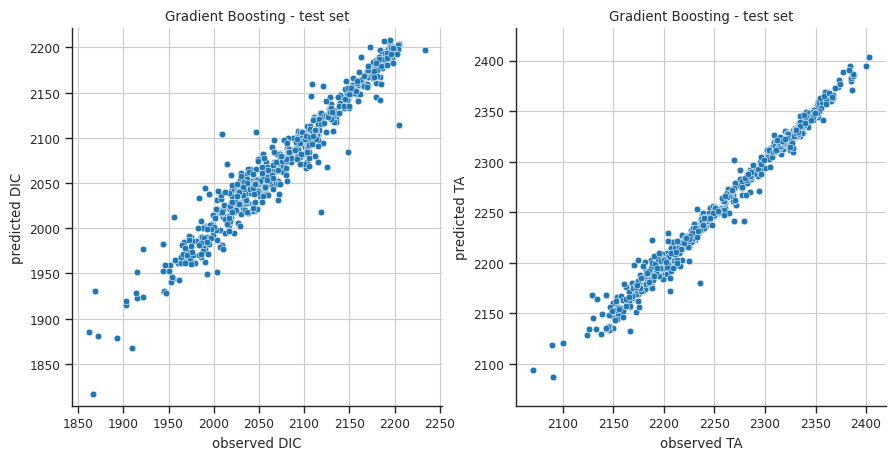

In [13]:
param_grid = {'base_estimator__n_estimators': [1500, 1700, 1900],
              'base_estimator__learning_rate':[0.01, 0.1],
              'base_estimator__max_depth':[3, 4]}
gs_gbrc2 = GridSearchCV(RegressorChain(GradientBoostingRegressor(random_state=0), order=[0,1]), param_grid, cv=5, n_jobs=-1)
gs_gbrc2.fit(X_train, Y_train);

print('Best cross-validation score: {:.3f}'.format(gs_gbrc2.best_score_))
print('Best parameters: {}'.format(gs_gbrc2.best_params_))
print('Best estimator: {}'.format(gs_gbrc2.best_estimator_))

print('Training set score: {:.3f}'.format(gs_gbrc2.score(X_train, Y_train)))
print('Test set score:     {:.3f}'.format(gs_gbrc2.score(X_test, Y_test)))

scores = cross_val_score(gs_gbrc2.best_estimator_, X, Y, cv=5, n_jobs=-1)
print('Final model cross-validation mean score: {:.3f}'.format(scores.mean()))

Y_pred = gs_gbrc2.predict(X_test)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10.5, 5))
_ = sns.scatterplot(x=Y_test[:,0], y=Y_pred[:,0], ax=ax0)
_ = sns.scatterplot(x=Y_test[:,1], y=Y_pred[:,1], ax=ax1)
_ = ax0.set(xlabel='observed DIC', ylabel='predicted DIC', title='Gradient Boosting - test set')
_ = ax1.set(xlabel='observed TA', ylabel='predicted TA', title='Gradient Boosting - test set')
ax0.axis('equal')
ax1.axis('equal')
sns.despine(fig)

##### Feature importance

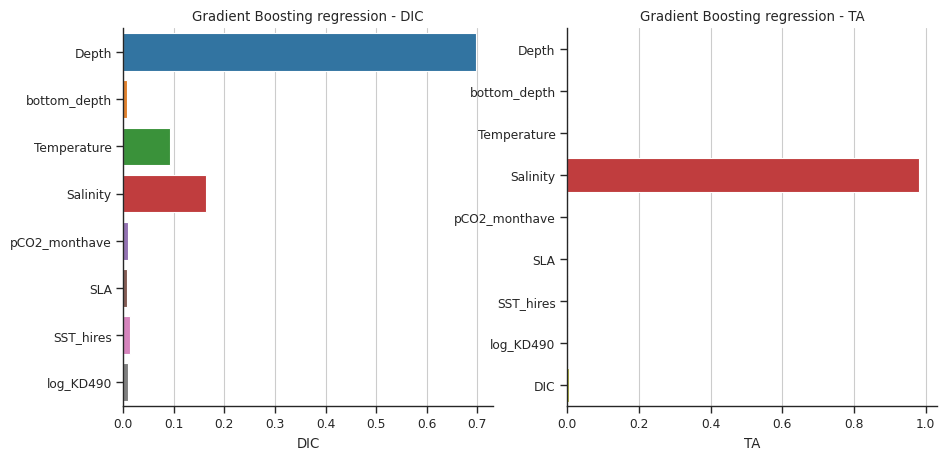

In [14]:
df1 = pd.DataFrame(gs_gbrc2.best_estimator_.estimators_[0].feature_importances_, index=features, columns=['DIC'])
df2 = pd.DataFrame(gs_gbrc2.best_estimator_.estimators_[1].feature_importances_, index=features+['DIC'], columns=['TA'])
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10.5,5))
_ = sns.barplot(data=df1, y=df1.index, x='DIC', orient='horizontal', ax=ax0)
_ = sns.barplot(data=df2, y=df2.index, x='TA', orient='horizontal', ax=ax1)
_ = ax0.set_title('Gradient Boosting regression - DIC')
_ = ax1.set_title('Gradient Boosting regression - TA')
sns.despine(fig)

### Neural Network regression 

Linear models and neural networks are very tied to the scale and distribution of each feature. Therefore, we rescale input features so they have mean=0 and std=1.

Using log-transformed Chl and KD490 does not change training, test and generalization scores significantly.

Best cross-validation score: 0.958
Best parameters: {'mlpregressor__activation': 'relu', 'mlpregressor__alpha': 0.0001, 'mlpregressor__hidden_layer_sizes': [400]}
Best estimator: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(hidden_layer_sizes=[400], random_state=42,
                              solver='lbfgs'))])
Training set score: 0.961
Test set score:     0.954
Final model cross-validation mean score: 0.930


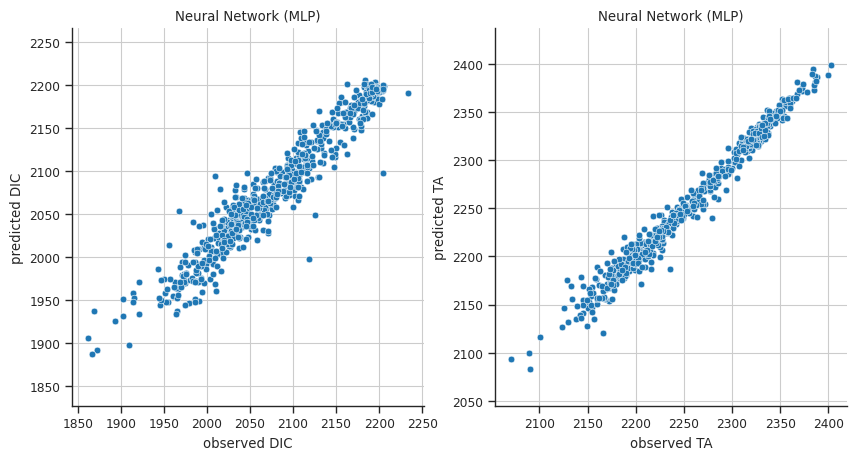

In [15]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline, make_pipeline

pipe = make_pipeline(StandardScaler(), MLPRegressor(solver='lbfgs', random_state=42))

param_grid = {'mlpregressor__hidden_layer_sizes': [[100,], [200,], [300,], [400,]],
              'mlpregressor__activation' : ['logistic', 'tanh', 'relu'],
              'mlpregressor__alpha': [0.0001, 0.001, 0.01]}
gs_nnr = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
gs_nnr.fit(X_train, Y_train);

print('Best cross-validation score: {:.3f}'.format(gs_nnr.best_score_))
print('Best parameters: {}'.format(gs_nnr.best_params_))
print('Best estimator: {}'.format(gs_nnr.best_estimator_))

print('Training set score: {:.3f}'.format(gs_nnr.score(X_train, Y_train)))
print('Test set score:     {:.3f}'.format(gs_nnr.score(X_test, Y_test)))

scores = cross_val_score(gs_nnr.best_estimator_, X, Y, cv=5, n_jobs=-1)
print('Final model cross-validation mean score: {:.3f}'.format(scores.mean()))

Y_pred = gs_nnr.predict(X_test)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
_ = sns.scatterplot(x=Y_test[:,0], y=Y_pred[:,0], ax=ax0)
_ = sns.scatterplot(x=Y_test[:,1], y=Y_pred[:,1], ax=ax1)
_ = ax0.set(xlabel='observed DIC', ylabel='predicted DIC', title='Neural Network (MLP)')
_ = ax1.set(xlabel='observed TA', ylabel='predicted TA', title='Neural Network (MLP)')
ax0.axis('equal')
ax1.axis('equal')
sns.despine(fig)

#### Feature importance

A possible interpretation of the distribution of hidden node weights is that features that have small (absolute value) weights for all hidden nodes are less important to the model.

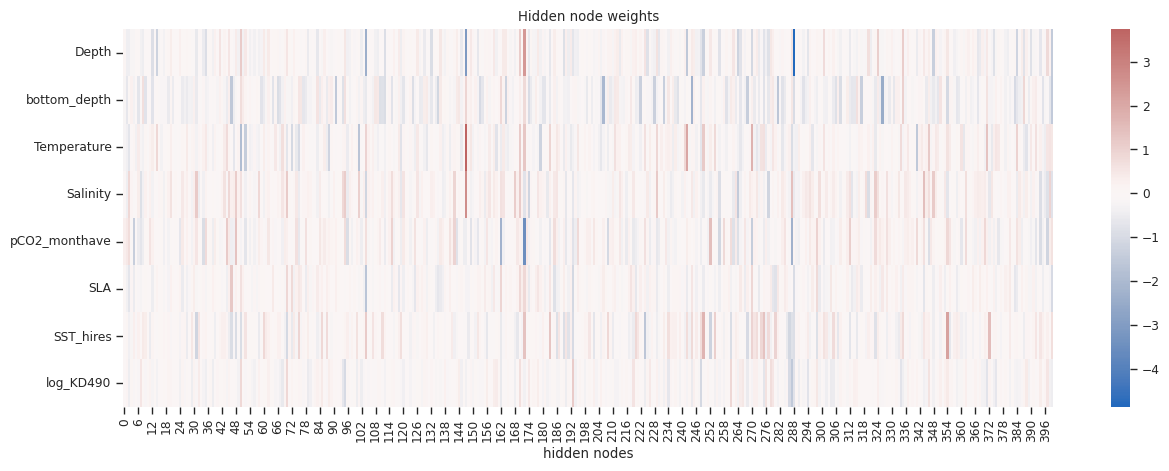

In [16]:
nn_weights = pd.DataFrame(gs_nnr.best_estimator_.named_steps['mlpregressor'].coefs_[0], index=features)
fig, ax = plt.subplots(figsize=(15, 5))
_ = sns.heatmap(nn_weights, center=0, cmap='vlag', ax=ax)
_ = ax.set(xlabel='hidden nodes', title='Hidden node weights')